In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, make_scorer, mean_squared_error, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import interp
import pickle
from pathlib import Path
import scikitplot as skplt
%matplotlib inline

In [2]:
# Be sure that final script is absolutely one level down repo root directory (e.g. /scripts/)
cwd = Path.cwd()
appdir = cwd.parents[0]
model_path = appdir/"model"
lncrna_path = appdir/"lncrna"
not_lncrna_path = appdir/"not_lncrna"

In [15]:
lncrna=pd.read_csv(model_path/'X_train_lncrna.csv')
lncrna["lncRNA"] = True
not_lncrna=pd.read_csv(model_path/'X_train_not_lncrna.csv')
not_lncrna["lncRNA"] = False
lncrna.drop(["mfe"], axis=1, inplace=True)
not_lncrna.drop(["none"], axis=1, inplace=True)
features = pd.DataFrame({})
features = pd.concat([lncrna, not_lncrna], ignore_index=True)
features.sort_values(ascending=True, by=["start", "end", "name"], inplace=True)

# I previously thought that droping NaN values was bust, but it doesn't seem right.
# Where there is no record for any of the UCSC tracks we will substitute NaN to 0.0
# The following code was removed
# features_clean = features.dropna(axis=0, how='any')
# dropped = 1 - len(features_clean) / len(features)
# print('Dropped ' + str(round(dropped, 3) * 100) + '% of rows from the original dataset due to NA values')


features_clean = features.fillna(0)

X = features_clean.iloc[:,3:14]
y = features_clean.iloc[:,-1]

In [4]:
features_clean

,name,start,end,length,bestTSS,bestTSS_inside,mean_gc,mean_remap,cov_me3,cov_tfbs,cov_pol2,mean_pcons27,mean_pPcons27,mean_pPcons124,lncRNA
236199,FBtr0100854,0,65,65,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
236200,FBtr0100854.1,0,65,65,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
236201,FBtr0100855,96,165,69,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
236202,FBtr0100855.1,96,165,69,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
236203,FBtr0100856,170,239,69,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189824,FBti0062173-RA.FlyBase.,32078313,32078882,569,0.0,0.0,46.1160,0.0,0.0,0.949033,0.0,0.0,0.0,0.0,False
189825,FBti0062189-RA.1.,32078568,32078658,90,0.0,0.0,56.6667,0.0,0.0,0.966667,0.0,0.0,0.0,0.0,False
189826,FBti0062189-RA.FlyBase.,32078568,32078658,90,0.0,0.0,56.6667,0.0,0.0,0.966667,0.0,0.0,0.0,0.0,False
189827,FBti0062191-RA.1.,32078882,32078912,30,0.0,0.0,29.3333,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,False


## Finding best parameters for the Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state=15)
param_grid = {
    'n_estimators' : [10, 25, 50, 100],
    'max_depth' : [3, 5, 7, 9],
    'min_samples_split' : [2, 4, 6, 8, 10],
    'min_samples_leaf' : [1, 2, 5, 10]
}
scoring = {
    'MSE': make_scorer(mean_squared_error),
    'AUC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score), 
    'Precision': make_scorer(precision_score)}
gs = GridSearchCV(rf, param_grid, verbose=3, n_jobs=-1, scoring="precision_macro")
gs.fit(X, y)

In [ ]:
results = gs.cv_results_
gs.best_estimator_

In [5]:
rf_best = RandomForestClassifier(n_jobs=-1)

from sklearn.model_selection import train_test_split
Xtr, Xts, Ytr, Yts = train_test_split(X, y, random_state=15)
Xtr.shape, Xts.shape, Ytr.shape, Yts.shape

((177206, 11), (59069, 11), (177206,), (59069,))

In [6]:
rf_best.fit(Xtr, Ytr)
Ypr = rf_best.predict(Xts)
print(accuracy_score(Yts, Ypr))
print(precision_score(Yts, Ypr))
print(recall_score(Yts, Ypr))
print(f1_score(Yts, Ypr))
print(roc_auc_score(Yts, Ypr))

0.9833076571467267
0.9261744966442953
0.5514485514485514
0.691296180338134
0.7749532521905347


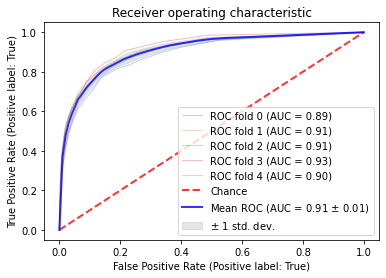

In [16]:
X=X.values
y=y.values
cv = KFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    rf_best.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        rf_best,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic",
)
ax.legend(loc="lower right")
plt.show()

In [17]:
X = features_clean.iloc[:,3:14]
y = features_clean.iloc[:,-1]
ft_imp = pd.Series(rf_best.feature_importances_, index=features_clean.iloc[:,3:14].columns).sort_values(ascending=False)
ft_imp

mean_pPcons124    0.138659
mean_pPcons27     0.120070
mean_pcons27      0.106028
length            0.102929
bestTSS           0.100222
mean_remap        0.098490
mean_gc           0.097032
bestTSS_inside    0.091886
cov_tfbs          0.074771
cov_pol2          0.054885
cov_me3           0.015028
dtype: float64

## Exported Model without 'cov_me3' and 'pPcons27'
pPcons27 & pPcons124 are highly correlated, so I am discarding pPcons27 since I have another algorythm for 27 insect conservation pcons27. Alhtough it is highly correlated with pPcons124, it is less than pPcons27.
I am also dropping cov_me3 since it doesn't help in the outcome of the classifier.
This was done for simplicity, I have to remember to remove these querys from the get-feature.sh script

In [22]:
kf = KFold(n_splits=5, shuffle=True, random_state=15)

def score_rf_model(X, y, kf):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    print("accuracy:", np.mean(accuracy_scores))
    print("precision:", np.mean(precision_scores))
    print("recall:", np.mean(recall_scores))
    print("f1:", np.mean(f1_scores))

In [23]:
X_best_ft = features_clean[["length", "bestTSS", "bestTSS_inside", "mean_gc", "mean_remap", "cov_tfbs", "cov_pol2", "mean_pcons27", "mean_pPcons124"]]
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_best_ft, y)
score_rf_model(X_best_ft, y, kf)

accuracy: 0.9846534758226643
precision: 0.925872066256367
recall: 0.5729845397299758
f1: 0.7078655445994502


In [ ]:
X_best_ft_arr = features_clean[["length", "bestTSS", "bestTSS_inside", "mean_gc", "mean_remap", "cov_tfbs", "cov_pol2", "mean_pcons27", "mean_pPcons124"]].values
y_arr=y.values

rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_best_ft_arr, y_arr)
score_rf_model(X_best_ft_arr, y_arr, kf)

accuracy: 0.9845857581208337
precision: 0.9252760291171345
recall: 0.5711319770350751
f1: 0.7062841669087565


### The previous cells show that there is no difference in using .values or pandas df 
(Probably because of the update to v1.X.X of sklearn. I was using version 0.24 before)

In [28]:
rf_final = RandomForestClassifier(n_jobs=-1)
rf_final.fit(X_best_ft, y)
score_rf_model(X_best_ft, y, kf)

accuracy: 0.984556131626283
precision: 0.9251714011747614
recall: 0.5701704287028233
f1: 0.7055170123102581


### Final shape of X features:

In [29]:
X_best_ft.columns

Index(['length', 'bestTSS', 'bestTSS_inside', 'mean_gc', 'mean_remap',
       'cov_tfbs', 'cov_pol2', 'mean_pcons27', 'mean_pPcons124'],
      dtype='object')

### Final model metrics

In [72]:
def score_model(X, y, model, splits):
    kf = KFold(n_splits=splits, shuffle=True, random_state=15)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    tn = []
    fp = []
    fn = []
    tp = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)

        # Compute standard scores and append
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # Compute confusion matrix and append
        cm = confusion_matrix(y_test, y_pred)
        tn.append(cm.ravel()[0]) 
        fp.append(cm.ravel()[1])
        fn.append(cm.ravel()[2])
        tp.append(cm.ravel()[3])

    # Average standard metrics
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    
    print("accuracy:", round(avg_accuracy, ndigits=3))
    print("precision:", round(avg_precision, ndigits=3))
    print("recall:", round(avg_recall, ndigits=3))
    print("f1:", round(avg_f1, ndigits=3))

    sc = {
        'accuracy' : accuracy_scores,
        'precision' : precision_scores,
        'recall' : recall_scores,
        'f1' : f1_scores,
    }

    scores = pd.DataFrame(data=sc)
    
    plt.boxplot(scores, labels=scores.columns)
    
    # Average confusion matrix
    avg_cm = np.array([[np.mean(tn), np.mean(fp)], [np.mean(fn), np.mean(tp)]], dtype=int)
    ConfusionMatrixDisplay(avg_cm).plot()

    return(y_pred, y_pred_prob)

In [57]:
rf_final = RandomForestClassifier(n_jobs=-1)
rf_final.fit(X_best_ft, y)

RandomForestClassifier(n_jobs=-1)

accuracy: 0.985
precision: 0.922
recall: 0.571
f1: 0.706


(array([False, False, False, ..., False, False, False]),
 array([[1.  , 0.  ],
        [0.93, 0.07],
        [1.  , 0.  ],
        ...,
        [1.  , 0.  ],
        [1.  , 0.  ],
        [1.  , 0.  ]]))

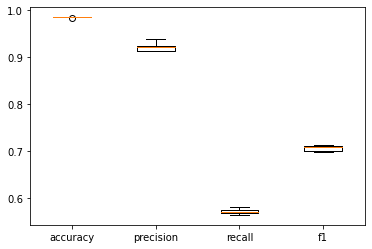

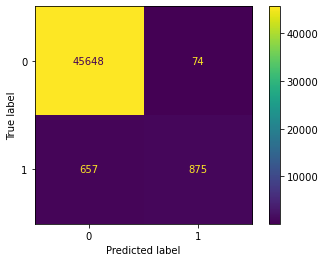

In [73]:
score_model(X_best_ft, y, rf_final, 5)

### Curve functions:

In [59]:
def draw_cv_roc_curve(classifier, cv, X, y, title='ROC Curve'):
    """
    Draw a Cross Validated ROC Curve.
    Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series
    Example largely taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    """
    # Creating ROC Curve with Cross Validation
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()


def draw_cv_pr_curve(classifier, cv, X, y, title='PR Curve'):
    """
    Draw a Cross Validated PR Curve.
    Keyword Args:
        classifier: Classifier Object
        cv: StratifiedKFold Object: (https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation)
        X: Feature Pandas DataFrame
        y: Response Pandas Series
        
    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    y_real = []
    y_proba = []

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        precision, recall, _ = precision_recall_curve(y.iloc[test], probas_[:, 1])
        
        # Plotting each individual PR Curve
        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y.iloc[test], probas_[:, 1])))
        
        y_real.append(y.iloc[test])
        y_proba.append(probas_[:, 1])

        i += 1
    
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    plt.plot(recall, precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (average_precision_score(y_real, y_proba)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

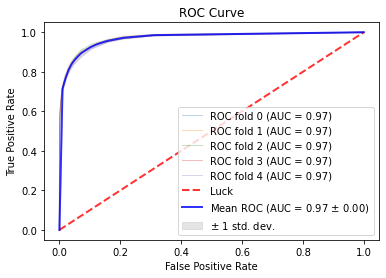

In [68]:
cv = KFold(n_splits=5, shuffle=True, random_state=15)
draw_cv_roc_curve(rf_final, cv, X_best_ft, y)

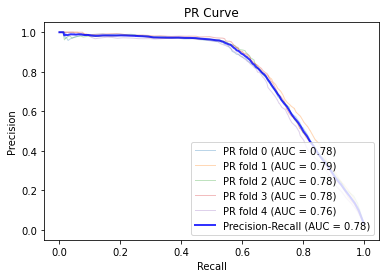

In [69]:
cv = KFold(n_splits=5, shuffle=True, random_state=15)
draw_cv_pr_curve(rf_final, cv, X_best_ft, y)

In [74]:
modelname = 'rf_dm6_lncrna_classifier.sav'
pickle.dump(rf_final, open(modelname, 'wb'))